In [34]:
import tables
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
from scipy.special import zetac
import scipy.optimize
from numba import jit
from itertools import izip, product
from commonPlot import plot_scan_exclusions, draw_xsec_sm, draw_hline_1

%matplotlib inline

In [35]:
pd.set_option('precision',7)
mpl.rcParams['figure.figsize'] = (9.0, 5.0)  # default size of plots
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.labelsize'] = 16

mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['ytick.minor.size'] = 5

mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['legend.framealpha'] = 0.85
mpl.rcParams['legend.scatterpoints'] = 1
mpl.rcParams['legend.numpoints'] = 1

# mpl.rcParams.update({'font.size': 24, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
mpl.rcParams.update({'font.size': 16, 'font.family': 'sans-serif', 'mathtext.fontset': 'cm'})


In [36]:
%config InlineBackend.figure_format='svg'
# %config InlineBackend.figure_format='retina'

In [37]:
mpl.rcParams['font.family'], mpl.rcParams['font.size'], mpl.rcParams['mathtext.fontset']

([u'sans-serif'], 16.0, u'cm')

# Some utility functions & physical constants

In [38]:
roman_dict = {1: 'I', 2: 'II', 3: 'III', 4: 'IV'}

def int_to_roman(i):
    """Convert integer to roman numeral. 
    Integer must in range 1 to 4.
    If no conversion exists, returns 'Z'
    """
    return roman_dict.get(i, 'Z')

In [39]:
# Some physical constants

G_F = 1.1663787E-5  # Fermi's constant, in (GeV)^-2

A_QED = 7.2973525664E-3 

sqrt2 = np.sqrt(2.)

PI = np.pi

# Quark masses in GeV. Both pole and MSBar
M_U_REF_SCALE = 2.
M_U_MSBAR_AT_REF = 2.3E-3

M_D_REF_SCALE = 2.
M_D_MSBAR_AT_REF = 4.8E-3

M_S_REF_SCALE = 2.
M_S_MSBAR_AT_REF = 95.0E-3

M_C_POLE = 1.275
M_C_MSBAR_AT_POLE = 1.275

M_B_POLE = 4.18
M_B_MSBAR_AT_POLE = 4.18

# update these
M_T_POLE = 170.3
M_T_MSBAR_AT_POLE = 170.3

# Some common lepton masses in GeV
M_TAU = 1.776
M_MU = 0.106
M_E = 0.5109989461E-3

# SM Higgs productionc cross-section in pb
SM_XSEC = 19.27

In [40]:
# these are for duck typing, since quark masses have to be called via functions
def m_tau(*args, **kwargs):
    return M_TAU

def m_mu(*args, **kwargs):
    return M_MU

def m_e(*args, **kwargs):
    return M_E

We **observe** a limit on a particular process, independent of the model. But to recast that limit **in a different channel** we need the correct transfer factors (i.e. ratio of BRs), which **are model-dependent**.

To convert between $BR(a \to \tau\tau)$, $BR(a \to \mu\mu)$, and $BR(a \to bb)$, we need to know how the values of the BR (or the widths). These are model-dependent, since in different models the particles couple to different doublets, introducing a potential $\tan\beta$ dependence into the realtive BR.

The different models are defined by couplings of the fermions to the Higgs doublets. These are shown below. In brackets is the $\tan \beta$ dependence, which is relative to the SM Higgs coupling. The SM coupling has an additional factor $im_f/v_i$ for leptons, and $-\gamma_5m_f/v_i$ for quarks

Note, $\tan\beta \equiv \text{v}_2/\text{v}_1$. Also note $g_{aVV} = 0$ for all models.

|Coupling/Type| I | II | III | IV|
|--------------------------------|
|$g_{a\tau\tau}$ | $H_2\\ (-\cot\beta)$ | $H_1\\ (\tan\beta)$ | $H_1\\ (\tan\beta)$ | $H_2\\ (-\cot\beta)$ |
|$g_{abb}$ | $H_2\\ (-\cot\beta)$ | $H_1\\ (\tan\beta)$ | $H_2\\ (-\cot\beta)$ | $H_1\\ (\tan\beta)$ |
|$g_{att}$ | $H_2\\ (\cot\beta)$ | $H_2\\ (\cot\beta)$ | $H_2\\ (\cot\beta)$ | $H_2\\ (\cot\beta)$ |

The NMSSM and MSSM are Type II.

The widths are defined as follows.

We use formulae A3 - A8 in 1312.4992v5 (whilst $\Gamma (a\to \gamma\gamma/gg)$ aren't required, they're included here for completeness)

\begin{align}
\Gamma(a\to \ell\ell) &= \frac{G_F}{4\sqrt{2}\pi}g_{a\ell\ell}^2 m_a m_{\ell}^2\sqrt{1-\left(\frac{2m_{\ell}}{m_a}\right)^2}
\\
\Gamma(a\to q\overline{q}) &= \frac{3 G_F}{4\sqrt{2}\pi}g_{aqq}^2 m_a \overline{m}_q^2\sqrt{1-\left(\frac{2\overline{m}_q}{m_a}\right)^2} \times \left(1 + \Delta_{q\overline{q}} + \Delta_a^2\right)
\\
&\mathrm{where\ the\ radiative\ corrections\ are}
\\
\Delta_{q\overline{q}} &= 5.67\frac{\overline{\alpha}_s}{\pi} +(35.64 -1.35N_f)\left(\frac{\overline{\alpha}_s}{\pi}\right)^2
\\
\Delta_a^2 &= \left(\frac{\overline{\alpha}_s}{\pi}\right)^2 \left(3.83 - \ln\frac{m_a^2}{m_t^2} + \frac{1}{6}\ln^2\frac{\overline{m}_q^2}{m_a^2} \right)
\\
\Gamma(a\to\gamma\gamma) &= \frac{G_F\alpha_{QED}^2 m_a^3}{128\sqrt{2}\pi^3} \left| \sum_f N_c Q_f^2 g_{aff} A^a_{1/2} \left( \frac{m_a^2}{4m_f^2} \right)\right|^2
\\
\Gamma(a\to gg) &= \frac{G_F\overline{\alpha}_s^2 m_a^3}{36\sqrt{2}\pi^3} \left|\frac{3}{4} \sum_{Q=t,b,c} g_{aQQ} A^a_{1/2} \left( \frac{m_a^2}{4\bar{m}_Q^2} \right)\right|^2 \times \left(1 + \left( \frac{97}{4} - \frac{7}{6}N_f\right)\frac{\overline{\alpha}_s}{\pi} \right)
\end{align}

Where:

- $\sqrt{1 - \left(2m_f / m_a\right)^2}$ is $\beta$, the "velocity" function

- $N_f$ is the number of active light quarks

- $\bar{\alpha}_s$ is the running strong coupling constant, evaulated at $m_a$

- $\bar{m}_q$ is the running quark mass in the $\overline{MS}$ scheme, evaluated at $m_a$

- $\alpha$ is the QED coupling constant

- $N_c$ is the number of colours (1 for leptons, 3 for quarks)

- $Q_f$ is the fermion charge in units of $e$

- $A^a_{1/2}$ is the "Universal scaling function":


\begin{equation}
A^a_{1/2}(x) = \frac{2f(x)}{x},\ f(x)=
  \begin{cases} 
   \arcsin^2\sqrt{x} & \text{if } x \leq 1 \\
   -\frac{1}{4}\left(\log\left(\frac{1 + \sqrt{1-1/x}}{1 - \sqrt{1- 1/x}}\right) - i\pi \right)^2       & \text{if } x > 1
  \end{cases}
\end{equation}


The running parameters are at scale $\mu = m_a$.

The widths to $\gamma\gamma$ and $gg$ are only via loops. Since this is the pseudoscalar under consideration, there is 0 contribution from W/Z in the $\gamma\gamma$ expression. However, if the charginos are light they can contribute. Additionally we ignore heavy SUSY particles as they are supressed. In $gg$, whilst the $t$-loop ususally dominates, if $\tan\beta$ is large then the $b$-loop may also have a significant contribution.

Therefore we need to calculate:

- running of $\bar{\alpha}_s$

- running of $\bar{m}_q$ (which depends on $\bar{\alpha}_s$)

## The easy part: converting $BR(a \to \tau\tau)$ $\Leftrightarrow$ $BR(a \to \mu\mu)$

This is fairly simple - both particles couple to the same doublet, since they are different generations of the same family. Therefore there is no $\tan \beta$ depedence.

Additionally, because we are dealing with leptons, there are no running masses involved. So the ratio simply reduces to the expression:

\begin{equation}
\frac{BR(a\to\tau\tau)}{BR(a \to \mu\mu)} = \frac{m_{\tau}^2}{m_{\mu}^2} \sqrt{\frac{1-\left(2m_{\tau}/m_a \right)^2}{1-\left(2m_{\mu}/m_a \right)^2}}
\end{equation}

which is the ratio of the Yukawa couplings, and the ratio of velocity factors.

In [41]:
def velocity(m_f, m_a):
    """beta factor ("phase volume") in width calculation

    m_f: mass of fermion
    m_a: mass of a boson. int, float, or numpy array
    
    if 2m_f > m_a, returns 0
    """
    if isinstance(m_a, float) or isinstance(m_a, int):
        if 2. * m_f > m_a:
            return 0.
    beta = np.sqrt(1 - (2 * m_f / m_a)**2)
    if isinstance(m_a, np.ndarray):
        beta[np.isnan(beta)] = 0.
    return beta


In [42]:
@jit
def convert_BR_final_states_simple(m_new, m_old, m_a, power=1):
    """Get ratio of widths (ie BR) of a -> 2m_new / a -> 2m_old
    This "simple" version only takes into account relative fermion masses.

    No tan(beta) dependence, no colour factors, no radiative corrections!
    
    Uses tree-level equation A3 in 1312.4992v5 
    (note, older versions miss a sqrt in phase factor!)
    """
    return m_new**2 * np.power(velocity(m_new, m_a), power) / (m_old**2 * np.power(velocity(m_old, m_a), power))

We can plot this:

In [43]:
M_a_STR = r'$m_a\ \mathrm{[GeV]}$'

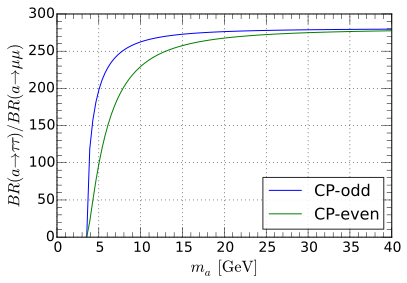

In [44]:
m_a = np.linspace(2*M_TAU, 40, 100)
ratio_pseudoscalar = convert_BR_final_states_simple(M_TAU, M_MU, m_a, power=1)
plt.gcf().set_size_inches(6, 4)
ratio_scalar = convert_BR_final_states_simple(M_TAU, M_MU, m_a, power=3)
plt.plot(m_a, ratio_pseudoscalar, label='CP-odd')
plt.plot(m_a, ratio_scalar, label='CP-even')
plt.xlabel(M_a_STR)
plt.ylabel(r'$BR(a\to\tau\tau) / BR(a\to\mu\mu)$')
plt.grid(which='major')
plt.minorticks_on()
# plt.suptitle("Pseudoscalar (power = 1)")
plt.legend(loc='best')

# The hard part: adding in $a\to bb$ & tan($\beta$) dependence

## Running of $\alpha_s$

References: 

- http://pdg.lbl.gov/2015/reviews/rpp2015-rev-qcd.pdf

- QCDNUM: https://www.nikhef.nl/~h24/qcdnum-files/doc/qcdnum170007.pdf

- A. Djouadi: Anatomy of EWSB I and II, arxiv:0503172, arxiv:0503173 

- Exotic Decays of the 125GeV Higgs Boson (Strassler et al), arxiv:1312.4992v5

Working in petrubative QCD (pQCD), the running of the coupling constant is determined by the renormalisation group equation (RGE) (PDG eq9.3):

\begin{equation}
\mu_R^2\frac{d\alpha_s^{(N_f)}}{d\mu_R^2} = \frac{d\alpha_s^{(N_f)}}{d\ln\mu_R^2} = \beta(\alpha_s^{(N_f)}) = -\sum_{i=0}^{\infty}b_i {\alpha_s^{(N_f)}}^{i+2}
\end{equation}

where the factors $b_i$ up to 3-loop are given by (b3 from 9701390v1):

\begin{align}
b_0 &= (33 - 2N_f)/(12\pi)
\\
b_1 &= (153 - 19N_f)/(24\pi^2)
\\
b_2 &= (2857 - \frac{5033}{9}N_f + \frac{325}{27}N_f^2)/(128\pi^3)
\\
b_3 &= \left( \left(\frac{149753}{6} + 3564N_f \right) - \left( \frac{1078361}{162} + \frac{6508}{27}\zeta(3)\right)N_f + \left( \frac{50065}{162} + \frac{6472}{81}\zeta(3) \right) N_f^2 + \frac{1093}{729}N_f^3 \right) / (\pi^4)
\end{align}

where $N_f$ is the number of "light" flavours $(m_q \ll \mu_R)$. The remaining flavours decouple from the theory. $\zeta$ is the Riemann zeta function ($\zeta(3) \simeq 1.202...$)

Note that the - sign is crucial for asymptotic freedom: higher scale = weaker coupling.

$b_i$ = "i+1 loop $\beta$-function coeff."

Note that the expressions for $b_i$ are scheme-dependent. Here we always work in the $\overline{MS}$ scheme.

Note that if one only considers $b_0$, a simple analytic solution exists:

\begin{equation}
\alpha_s(\mu_R^2) = \frac{1}{b_0\ln\left(\mu_R^2/\Lambda^2\right)}
\end{equation}

where $\Lambda$ is a constant, representing the limit to which pQCD can be applied before non-perturbative effectes render the approach invalid.

Considering higher orders, an approximate analytic solution exists up to 3-loop order (PDG eq9.5):

\begin{equation}
\alpha_s(\mu_R^2) \simeq \frac{1}{b_0t}\left(1 - \frac{b_1}{b_0^2}\frac{\ln t}{t} + \frac{b_1^2\left(\ln^2 t- \ln t - 1 \right)+b_0 b_2}{b_0^4 t^2} - \frac{b_1^3 \left( \ln^3t -\frac{5}{2}\ln^2t -2\ln t + \frac{1}{2} \right) + 3b_0 b_1 b_2\ln t - \frac{1}{2}b_0^2 b_3}{b_0^6 t^3} \right)
\end{equation}

where

\begin{equation}
t = \ln \frac{\mu_R^2}{\Lambda^2}
\end{equation}

Another subtelty enters when one considers the number of quarks contributing to $N_f$. When $\mu$ exceeds a heavier quark mass, it must be included. To relate the coupling for $N_F+1$ to $N_f$, the following formula is used (PDG eq9.4):

\begin{equation}
\alpha_s^{(N_f+1)}(\mu_R^2) = \alpha_s^{(N_f)}\left( 1 + \sum_{n=1}^\infty \sum_{\ell=0}^n c_{n\ell} \left[  \alpha_s^{(N_f)}\left( \mu_R^2 \right)\right]^n \ln^\ell \frac{\mu_R^2}{m_Q} \right)
\end{equation}

where $m_Q$ is the flavour of the $(N_f+1)$ quark. The first few constants $c_{n\ell}$ are:

\begin{align}
c_{10} &= 0
\\
c_{11} &= 1/6\pi
\\
c_{20} &= -11/(72\pi^2)
\\
c_{21} &= 19/(24\pi^2)
\\
c_{22} &= 1/(36\pi^2)
\end{align}

These are valid when $m_Q$ is the $\overline{MS}$ mass at scale $m_Q$. If the pole mass is used, the only difference is now $c_{20} = 7/(24\pi^2)$

So there are 2 approaches that can be used to calculate $\alpha_s$ at any scale, starting from a reference value at a given scale $\mu_{ref}$ with a given $N_f$. Typically $\alpha_s(M_Z^2) = 0.1181$ is used

1) Determine $\Lambda$ via the approximate analytic solution. From there, one can determine $\alpha_s$ at any other scale.

2) Solve the RGE using $\alpha_s(\mu^2)|_{\mu = \mu_{ref}} = \alpha_s(\mu_{ref}^2)$

Handily, the PDG has calcualted $\Lambda^{(N_f)}_{\overline{MS}}$ for the above reference value of $\alpha_s$ using the approximate analytic expression to 4-loop, and 3-loop matching at pole masses 1.3 (c), 4.2 (b), and 173 (t) GeV.

(Although, even if they didn't we can use scipy.optimize.XXX to find the solution for lambda given a reference $\alpha_s, \mu$.)

**Note** that these are only valid down to a few GeV - below that the analytic expression isn't very accurate, and one must solve the RGE.

\begin{align}
\Lambda_{\overline{MS}}^{(6)} &= 89\ \mathrm{MeV}
\\
\Lambda_{\overline{MS}}^{(5)} &= 210\ \mathrm{MeV}
\\
\Lambda_{\overline{MS}}^{(4)} &= 291\ \mathrm{MeV}
\\
\Lambda_{\overline{MS}}^{(3)} &= 332\ \mathrm{MeV}
\end{align}

In [45]:
@jit
def n_flav(mu):
    """Return number of light flavours, 
    i.e. number of quarks with mass < mu"""
    if mu < M_C_POLE:
        return 3
    elif mu < M_B_POLE:
        return 4
    elif mu < M_T_POLE:
        return 5
    else:
        return 6

In [46]:
zeta3 = zetac(3)+1

@jit
def alpha_s(mu, nflav=None, simple=False):
    """Calculate strong coupling constant at any scale.

    simple : bool. Do 1-loop only. Overly large at small mu, but faster.
    """

    if not nflav:
        nflav = n_flav(mu)

    lambda_ = 0  # use underscore to avoid clashing with python builtin        
    if nflav == 3:
        lambda_ = 0.332
    elif nflav == 4:
        lambda_ = 0.291
    elif nflav == 5:
        lambda_ = 0.210
    elif nflav == 6:
        lambda_ = 0.089
    else:
        raise RuntimeError('n_flav not in range [3, 6] for alpha_s')
        
    # RGE constants, using PDG convention
    b0 = (33. - 2.*nflav) / (12. * PI)
    
    if simple:
        return 1. / (b0 * np.log(mu**2/lambda_**2))

    b1 = (153 - 19*nflav) / (24. * PI**2)
    
    b2 = (2857 - (5033. * nflav / 9.) + (325. * nflav**2 / 27.)) / (128. * PI**3)
    
    
    b3_0 = ((149753/6.) + (3564.*zeta3))
    b3_1 = ((1078361./162.) + (6508.*zeta3/27.)) * nflav
    b3_2 = ((50065./162.) + (6472.*zeta3/81.)) * nflav**2 
    b3_3 = (1093./729.) * nflav**3
    b3 = (b3_0 - b3_1 + b3_2 + b3_3) / (256. * PI**4)
   
    # calculate the analytic approximation, using PDG convention
    t = np.log((mu**2) / (lambda_**2))
    lnt = np.log(t)
    
    part1 = 1
    part2 = ((b1 * lnt) / (b0**2 * t))
    part3 = ((b1**2 * (lnt**2 - lnt - 1)) + (b0*b2)) / (b0**4 * t**2)
    part4 = (b1**3 * (lnt**3 - (2.5*lnt**2) - (2*lnt) + 0.5) + (3*b0*b1*b2*lnt) - (0.5 * b0**2 * b3)) / (b0**6 * t**3)
    return (part1 - part2 + part3 - part4) / (b0*t)

In [47]:
print 'MZ', alpha_s(91.1882, 5), 'should be 0.1181'

MZ 0.118139662993 should be 0.1181


In [48]:
# Calculate a_s for various scales, covering 1 GeV to 2 TeV,
# comparing 4 loop with 1 loop

# For log x scale:
Q_ranges = [np.logspace(0, np.log10(1.3), 20), np.logspace(np.log10(1.3), np.log10(4.2), 20), 
            np.logspace(np.log10(4.2), np.log10(173), 50), np.logspace(np.log10(173), np.log10(2000), 100)]
Q = np.concatenate(Q_ranges)

a_s = np.concatenate([alpha_s(qr, i+3) for i, qr in enumerate(Q_ranges)])
a_s_1loop = np.concatenate([alpha_s(qr, i+3, True) for i, qr in enumerate(Q_ranges)])

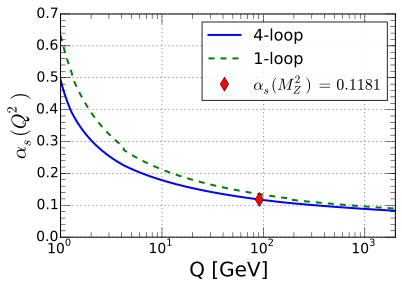

In [49]:
plt.gcf().set_size_inches(6, 4)
plt.plot(Q, a_s, label='4-loop', linewidth=2)
plt.plot(Q, a_s_1loop, label='1-loop', linestyle='dashed', linewidth=2)
# plt.plot(Q, [alpha_s(q) for q in Q], linestyle="dotted", linewidth=2, color='orange')
plt.plot([91.1876], [0.1181], 'dr', label=r'$\alpha_s(M_Z^2)\ =\ 0.1181$', markersize=10)
plt.xlim(1, 2000)
plt.xscale('log')
plt.xlabel('Q [GeV]', fontsize=20)
# plt.ylim(0.05, 0.4)
plt.ylabel(r'$\alpha_s(Q^2)$', fontsize=20)
plt.legend(fontsize=16, loc=0)
plt.minorticks_on()
plt.grid()

## Running of quark masses 

The renormalisation group equations for mass are:

\begin{equation}
\mu^2\frac{d\overline{m}(\mu)}{d\mu^2} = -\gamma(\overline{\alpha}_s(\mu))\overline{m}(\mu)
\end{equation}

where $\mu$ is the scale parameter, $\overline{m}$ is the running mass in the $\overline{MS}$ scheme, $\overline{\alpha}_s$ the running strong coupling, and $\gamma$ the "anomalous dimension".

$\gamma$ can be written as a power series expansion with coefficients $\gamma_r$:

\begin{equation}
\gamma(\overline{\alpha}_s) = \sum_{r=1}^{\infty} \gamma_r \left(\frac{\overline{\alpha}_s}{4\pi} \right)^r
\end{equation}

The first 4 coefficents are:

\begin{align}
\gamma_1 &= 4
\\
\gamma_2 &= \frac{202}{3} - \frac{20N_L}{9}
\\
\gamma_3 &= 1249 + \left( -\frac{2216}{27} - \frac{160}{3}\zeta(3)\right)N_L - \frac{140}{81}N_L^2
\\
\gamma_4 &= \frac{4603055}{162} + \frac{135680}{27}\zeta(3) - 8800\zeta(5) 
\\
&+ \left( - \frac{91723}{27} -\frac{34192}{9}\zeta(3) + 880\zeta(4) + \frac{18400}{9}\zeta(5) \right)N_L 
\\ 
&+ \left(\frac{5242}{243} + \frac{800}{9}\zeta(3) - \frac{160}{3}\zeta(4) \right)N_L^2 
\\
&+ \left(-\frac{332}{243} + \frac{64}{27}\zeta(3) \right)N_L^3 
\end{align}

where $N_L$ is the number of active "light" quark flavours, i.e. with mass < $\mu$. $\zeta$ is the Riemann zeta function. $\zeta(3) \simeq 1.202,\ \zeta(4) \simeq 1.082,\ \zeta(5) \simeq 1.037$.

We can combine the RGE for $\alpha_s$ into the RGE for mass The mass at a scale $\mu$ can be calculated from a reference mass at a reference scale $\overline{m}(\mu_0)$:

\begin{equation}
\frac{\overline{m}(\mu)}{\overline{m}(\mu_0)} = \frac{c(\overline{\alpha}_s(\mu)/\pi)}{c(\overline{\alpha}_s(\mu_0)/\pi)}
\end{equation}

where the function c, up to 3-loop, is:

\begin{align}
c(x) = \text{some very long formula}
\end{align}

An approximation is given by [Djouadi] [970448v1]:

\begin{align}
c^{(3)}(x) &= (x)^{4/9}\left( 1 + 0.895062x + 1.37143x^2 + 1.95168x^3\right) &m_s < \mu < m_c
\\
c^{(4)}(x) &= (x)^{12/25}\left( 1 + 1.014x + 1.389x^2 + 1.091x^3\right) &m_c < \mu < m_b
\\
c^{(5)}(x) &= (x)^{12/23}\left(1 + 1.175x + 1.501x^2 + 0.1725x^3\right) &m_b < \mu < m_t
\\
c^{(6)}(x) &= (x)^{4/7} \left(1 + 1.398x + 1.793x^2 - 0.6834x^3\right) &m_t < \mu
\end{align}

(Note tha Djouadi has extra factors in the first bracket, but other papers don't...)

To ensure that masses match at boundaries, the mass & scale at the boundary must be used as a reference vale when using $c^{(N_F+1)}(x)$, e.g. when calculating $m_c$ for $\mu > m_b$, use $\overline{m}_c (m_b)$ as the reference value.

To convert the pole mass $m_Q$ to $\overline{MS}$ mass $\overline{m}_Q$, the following eqatuion is used (up to 3 loop):

\begin{align}
\overline{m}_Q(m_Q) = m_Q \left( 1 - \frac{4}{3}\frac{\alpha_s(m_Q)}{\pi} \right) + ...
\end{align}

Take $c^{(N_F)}(x)$ from 9703278, 9703284: (Note, Djaoudi (EWSB I) and HDECAY use old formulae, with additional factors in front - not sure if correct?)

In [50]:
@jit
def c_3flav(x):
    return (x)**(4./9.) * (1 + 0.895062*x + 1.37143*x**2 + 1.95168*x**3)

In [51]:
@jit
def c_4flav(x):
    return (x)**(12./25.) * (1 + 1.01413*x + 1.38921*x**2 + 1.09054*x**3)

In [52]:
@jit
def c_5flav(x):
    return (x)**(12./23.) * (1 + 1.17549*x + 1.50071*x**2 + 0.172478*x**3)

In [53]:
@jit
def c_6flav(x):
    return (x)**(4./7.) * (1 + 1.39796*x + 1.79348*x**2 - 0.683433*x**3)

In [54]:
def m_s_msbar(mu):
    if mu < M_S_MSBAR_AT_REF:
        raise RuntimeError('mu < M_S - cannot calculate c(x)')

    elif mu < M_C_POLE:
        # can use normal reference values
        x = alpha_s(mu, 3) / PI
        x_ref_s_3 = alpha_s(M_S_REF_SCALE, 3) / PI
        return M_S_MSBAR_AT_REF * c_3flav(x) / c_3flav(x_ref_s_3)
    
    elif mu < M_B_POLE:
        # use 3flav value at M_C_POLE as reference
        x = alpha_s(mu, 4) / PI
        x_ref_c_4 = alpha_s(M_C_POLE, 4) / PI
        x_ref_c_3 = alpha_s(M_C_POLE, 3) / PI
        x_ref_s_3 = alpha_s(M_S_REF_SCALE, 3) / PI
        m_ref = M_S_MSBAR_AT_REF * c_3flav(x_ref_c_3) / c_3flav(x_ref_s_3)
        return m_ref * c_4flav(x) / c_4flav(x_ref_c_4)

    elif mu < M_T_POLE:
        # use 4flav value at M_B_POLE as reference
        x = alpha_s(mu, 5) / PI
        x_ref_5 = alpha_s(M_B_POLE, 5) / PI
        x_ref_b_4 = alpha_s(M_B_POLE, 4) / PI
        x_ref_c_4 = alpha_s(M_C_POLE, 4) / PI
        x_ref_c_3 = alpha_s(M_C_POLE, 3) / PI
        x_ref_s_3 = alpha_s(M_S_REF_SCALE, 3) / PI
        m_ref = M_S_MSBAR_AT_REF * (c_3flav(x_ref_c_3) / c_3flav(x_ref_s_3)) * (c_4flav(x_ref_b_4) / c_4flav(x_ref_c_4))
        return m_ref * c_5flav(x) / c_5flav(x_ref_5)
    
    else:
        # use 5flav value at M_T_POLE as reference
        return 0

In [55]:
def m_s_msbar_alt(mu):
    x = alpha_s(mu, 3) / PI
    x_ref = alpha_s(M_S_REF_SCALE, 3) / PI
    return M_S_MSBAR_AT_REF * c_3flav(x) / c_3flav(x_ref)

In [56]:
@jit
def m_c_msbar(mu):
    if mu < M_S_MSBAR_AT_REF:
        return 0
    
    elif mu < M_C_POLE:
        # Use 4flav value at M_C_POLE as reference
        x = alpha_s(mu, 3) / PI
        x_ref_c_3 = alpha_s(M_C_POLE, 3) / PI
        m_ref = M_C_MSBAR_AT_POLE
        return m_ref * c_3flav(x) / c_3flav(x_ref_c_3)
        
    elif mu < M_B_POLE:
        # can use normal reference value
        x = alpha_s(mu, 4) / PI
        x_ref_c_4 = alpha_s(M_C_POLE, 4) / PI
        return M_C_MSBAR_AT_POLE * c_4flav(x) / c_4flav(x_ref_c_4)

    elif mu < M_T_POLE:
        # use 4flav value at M_B_POLE as reference
        x = alpha_s(mu, 5) / PI
        x_ref_b_5 = alpha_s(M_B_POLE, 5) / PI
        x_ref_b_4 = alpha_s(M_B_POLE, 4) / PI
        x_ref_c_4 = alpha_s(M_C_POLE, 4) / PI
        m_ref = M_C_MSBAR_AT_POLE * c_4flav(x_ref_b_4) / c_4flav(x_ref_c_4)
        return m_ref * c_5flav(x) / c_5flav(x_ref_b_5)

    else:
        # use 5flav value at M_T_POLE as reference
        x = alpha_s(mu, 6) / PI
        x_ref_t_6 = alpha_s(M_T_POLE, 6) / PI
        x_ref_t_5 = alpha_s(M_T_POLE, 5) / PI
        x_ref_b_5 = alpha_s(M_B_POLE, 5) / PI
        x_ref_b_4 = alpha_s(M_B_POLE, 4) / PI
        x_ref_c_4 = alpha_s(M_C_POLE, 4) / PI
        m_ref = M_C_MSBAR_AT_POLE * (c_4flav(x_ref_b_4) / c_4flav(x_ref_c_4)) * (c_5flav(x_ref_t_5) / c_5flav(x_ref_b_5))
        return m_ref * c_6flav(x) / c_6flav(x_ref_t_6)

In [57]:
@jit
def m_b_msbar(mu):
    if mu < M_S_MSBAR_AT_REF:
        return 0
    
    elif mu < M_C_POLE:
        # use 4flav value at M_C_POLE as reference
        x = alpha_s(mu, 3) / PI
        x_ref_c_3 = alpha_s(M_C_POLE, 3) / PI
        x_ref_c_4 = alpha_s(M_C_POLE, 4) / PI
        x_ref_b_4 = alpha_s(M_B_POLE, 4) / PI
        m_ref = M_B_MSBAR_AT_POLE * c_4flav(x_ref_c_4) / c_4flav(x_ref_b_4)
        return m_ref * c_3flav(x) / c_3flav(x_ref_c_3)
    
    elif mu < M_B_POLE:
        # use 5flav value at M_B_POLE as reference
        x = alpha_s(mu, 4) / PI
        x_ref_b_4 = alpha_s(M_B_POLE, 4) / PI
        m_ref = M_B_MSBAR_AT_POLE
        return m_ref * c_4flav(x) / c_4flav(x_ref_b_4)
    
    elif mu < M_T_POLE:
        # use normal ref value
        x = alpha_s(mu, 5) / PI
        x_ref_b_5 = alpha_s(M_B_POLE, 5) / PI
        return M_B_MSBAR_AT_POLE * c_5flav(x) / c_5flav(x_ref_b_5)
    
    else:
        # use 5flav value at M_T_POLE as reference
        x = alpha_s(mu, 6) / PI
        x_ref_t_5 = alpha_s(M_T_POLE, 5) / PI
        x_ref_t_6 = alpha_s(M_T_POLE, 6) / PI
        x_ref_b_5 = alpha_s(M_B_POLE, 5) / PI
        m_ref = M_B_MSBAR_AT_POLE * c_5flav(x_ref_t_5) / c_5flav(x_ref_b_5)
        return m_ref * c_6flav(x) / c_6flav(x_ref_t_6)

In [58]:
m_b_msbar(161)

2.72725687506236

In [59]:
@jit
def m_t_msbar(mu):   
    if mu < M_S_MSBAR_AT_REF:
        return 0
    
    elif mu < M_C_POLE:
        # use 4flav value at M_C_POLE as reference
        x = alpha_s(mu, 3) / PI
        x_ref_c_3 = alpha_s(M_C_POLE, 3) / PI
        x_ref_c_4 = alpha_s(M_C_POLE, 4) / PI
        x_ref_b_4 = alpha_s(M_B_POLE, 4) / PI
        x_ref_b_5 = alpha_s(M_B_POLE, 5) / PI
        x_ref_t_5 = alpha_s(M_T_POLE, 5) / PI
        m_ref = M_T_MSBAR_AT_POLE * (c_5flav(x_ref_b_5) / c_5flav(x_ref_t_5)) *  (c_4flav(x_ref_c_4) / c_4flav(x_ref_b_4))
        return m_ref * c_3flav(x) / c_3flav(x_ref_c_3)
    
    elif mu < M_B_POLE:
        # use 5flav value at M_B_POLE as reference
        x = alpha_s(mu, 4) / PI
        x_ref_b_4 = alpha_s(M_B_POLE, 4) / PI
        x_ref_b_5 = alpha_s(M_B_POLE, 5) / PI
        x_ref_t_5 = alpha_s(M_T_POLE, 5) / PI
        m_ref = M_T_MSBAR_AT_POLE * c_5flav(x_ref_b_5) / c_5flav(x_ref_t_5)
        return m_ref * c_4flav(x) / c_4flav(x_ref_b_4)
        
    elif mu < M_T_POLE:
        # use 6flav value at M_T_POLE as reference
        x = alpha_s(mu, 5) / PI
        x_ref_t_5 = alpha_s(M_T_POLE, 5) / PI
        m_ref = M_T_MSBAR_AT_POLE
        return m_ref * c_5flav(x) / c_5flav(x_ref_t_5)

    else:
        # use normal ref value
        x = alpha_s(mu, 6) / PI
        x_ref_t_6 = alpha_s(M_T_POLE, 6) / PI
        return M_T_MSBAR_AT_POLE * c_6flav(x) / c_6flav(x_ref_t_6)


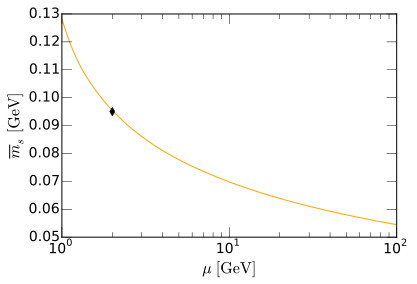

In [60]:
plt.gcf().set_size_inches(6, 4)
mu_range = np.logspace(np.log10(1), np.log10(100), 500)
m_s_range = np.array([m_s_msbar(mus) for mus in mu_range])
plt.plot(mu_range, m_s_range, color='orange')
# m_s_range_alt = np.array([m_s_msbar_alt(mus) for mus in mu_range])
# plt.plot(mu_range, m_s_range_alt, color='red')
plt.plot([M_S_REF_SCALE], [M_S_MSBAR_AT_REF], 'dk')
# plt.plot([1,10], [1,10])
plt.xscale('log')
plt.xlabel(r'$\mu \mathrm{\ [GeV]}$')
plt.ylabel(r'$\overline{m}_s \mathrm{\ [GeV]}$')

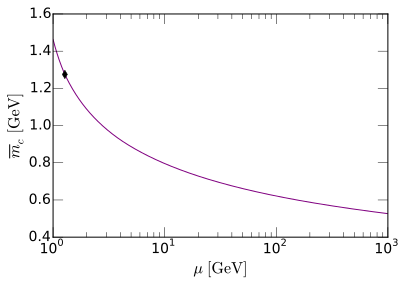

In [61]:
plt.gcf().set_size_inches(6, 4)
mu_range = np.logspace(np.log10(1), 3, 500)
m_c_range = np.array([m_c_msbar(muc) for muc in mu_range])
plt.plot(mu_range, m_c_range, color='purple')
plt.plot([M_C_POLE], [M_C_MSBAR_AT_POLE], 'dk')
# plt.plot([1,10], [1,10])
plt.xscale('log')
plt.xlabel(r'$\mu \mathrm{\ [GeV]}$')
plt.ylabel(r'$\overline{m}_c \mathrm{\ [GeV]}$')

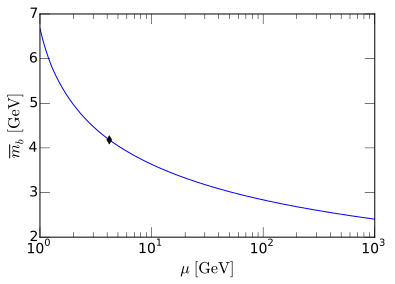

In [62]:
plt.gcf().set_size_inches(6, 4)
m_b_range = np.array([m_b_msbar(mub) for mub in mu_range])
plt.plot(mu_range, m_b_range)
plt.plot([M_B_POLE], [M_B_MSBAR_AT_POLE], 'dk')
# plt.plot(np.linspace(1, 11, 20), np.linspace(1, 11, 20))
plt.xscale('log')
plt.xlabel(r'$\mu \mathrm{\ [GeV]}$')
plt.ylabel(r'$\overline{m}_b \mathrm{\ [GeV]}$')

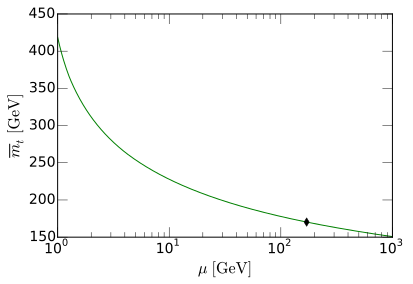

In [63]:
plt.gcf().set_size_inches(6, 4)
mu_range = np.logspace(np.log10(1), 3, 500)
m_t_range = np.array([m_t_msbar(mut) for mut in mu_range])
plt.plot(mu_range, m_t_range, color='green')
plt.plot([M_T_POLE], [M_T_MSBAR_AT_POLE], 'dk')
# plt.plot(np.linspace(1, 200, 20), np.linspace(1, 200, 20))
plt.xscale('log')
plt.xlabel(r'$\mu \mathrm{\ [GeV]}$')
plt.ylabel(r'$\overline{m}_t \mathrm{\ [GeV]}$')

Now we need various formulae to convert BR, as well as calculating the exact BR.

In [64]:
def g_aqq_up(model_type, tan_beta):
    """a-quark-quark (up quark type) reduced coupling"""
    return 1./tan_beta

In [65]:
def g_aqq_down(model_type, tan_beta):
    """a-quark-quark (down quark type) reduced coupling"""
    if model_type in [1, 3]:
        return 1./tan_beta
    elif model_type in [2, 4]:
        return tan_beta
    else:
        raise RuntimeError("model_type must be one of [1, 2, 3, 4]")

In [66]:
def g_all(model_type, tan_beta):
    """a-lepton-lepton reduced coupling"""
    if model_type in [1, 4]:
        return 1./tan_beta
    elif model_type in [2, 3]:
        return tan_beta
    else:
        raise RuntimeError("model_type must be one of [1, 2, 3, 4]")

In [67]:
@jit
def rad_corr(m_q, m_a):
    """Calculate radiative corrections for aqq coupling."""
    NF = n_flav(m_a)
    a_s_ov_pi = alpha_s(m_a, NF) / PI
    delta_qq = (5.67 * a_s_ov_pi) + (35.94 - 1.35*NF)*a_s_ov_pi**2
    delta_a2 = a_s_ov_pi**2 * (3.83 - np.log((m_a / M_T_POLE)**2) + (np.log((m_q / m_a)**2)**2)/6.)
    return 1 + delta_qq + delta_a2

In [68]:
def width_a_lepton_common(m_a, m_l, model_type, tan_beta):
    if 2*m_l > m_a:
        return 0
    return g_all(model_type, tan_beta)**2 * m_l**2 * velocity(m_l, m_a)

In [69]:
def width_a_quark_common(m_a, m_q, model_type, tan_beta):
    if 2*m_q > m_a:
        return 0
#     print rad_corr(m_q, m_a)
    return 3. * g_aqq_down(model_type, tan_beta)**2 * m_q**2 * velocity(m_q, m_a) * rad_corr(m_q, m_a)

In [70]:
def ll_to_qq(m_a, m_l, m_q, model_type, tan_beta):
    """Ratio of BR(a->qq) / BR(a->ll), down type q

    Needs a mass, lepton mass, q mass, model type (1, 2, 3, 4) and tan_beta.
    """
#     return br_a_bb(m_a, model_type, tan_beta) / br_a_tautau(m_a, model_type, tan_beta)
    return width_a_quark_common(m_a, m_q, model_type, tan_beta) / width_a_lepton_common(m_a, m_l, model_type, tan_beta)

def qq_to_ll(m_a, m_q, m_l, model_type, tan_beta):
    """Ratio of BR(a->ll) / BR(a->qq), down type q

    Needs a mass, lepton mass, q mass, model type (1, 2, 3, 4) and tan_beta.
    """
    return width_a_lepton_common(m_a, m_l, model_type, tan_beta) / width_a_quark_common(m_a, m_q, model_type, tan_beta)

In [71]:
print ll_to_qq(20., M_TAU, m_b_msbar(20.), model_type=2, tan_beta=10)
# print br_a_bb(20, 2, 10) / br_a_tautau(20, 2, 10)

13.8223587888


In [72]:
print ll_to_qq(10., M_TAU, M_B_MSBAR_AT_POLE, model_type=3, tan_beta=10)
# print br_a_bb(10., 3, 10) / br_a_tautau(10., 3, 10)
print ll_to_qq(10., M_TAU, M_B_MSBAR_AT_POLE, model_type=4, tan_beta=10)
# print br_a_bb(10., 4, 10) / br_a_tautau(10., 4, 10)

0.00141378386205
141378.386205


Plot the ratio as a function of $m_a$ for choice $\tan\beta$:

In [73]:
m_a = np.logspace(np.log10(1.98*M_B_MSBAR_AT_POLE), np.log10(60), 50)
br_ratio_typ1 = np.array([ll_to_qq(m, M_TAU, m_b_msbar(m), 1, 1) for m in m_a])
br_ratio_typ2_tb0p5 = np.array([ll_to_qq(m, M_TAU,  m_b_msbar(m), 2, 0.5) for m in m_a])
br_ratio_typ2_tb5 = np.array([ll_to_qq(m, M_TAU,  m_b_msbar(m), 2, 5) for m in m_a])
br_ratio_typ3_tb0p5 = np.array([ll_to_qq(m, M_TAU,  m_b_msbar(m), 3, 0.5) for m in m_a])
br_ratio_typ3_tb5 = np.array([ll_to_qq(m, M_TAU,  m_b_msbar(m), 3, 5) for m in m_a])
br_ratio_typ4_tb0p5 = np.array([ll_to_qq(m, M_TAU,  m_b_msbar(m), 4, 0.5) for m in m_a])
br_ratio_typ4_tb5 = np.array([ll_to_qq(m, M_TAU,  m_b_msbar(m), 4, 5) for m in m_a])

/Users/robina/.virtualenvs/NMSSMScan/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


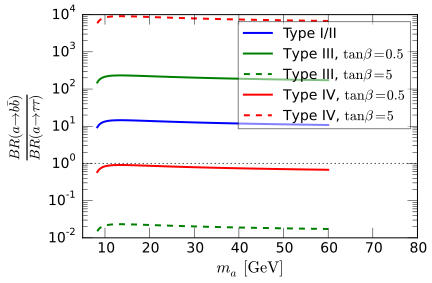

In [74]:
plt.gcf().set_size_inches(6, 4)
plt.plot(m_a, br_ratio_typ1, label='Type I/II', linewidth=2)
# plt.plot(m_a, br_ratio_typ2_tb0p5, label='Type II (0.5)', linewidth=1)
# plt.plot(m_a, br_ratio_typ2_tb5, label='Type II (5)', linewidth=1, color='orange', linestyle='dashed')
plt.plot(m_a, br_ratio_typ3_tb0p5, label='Type III, '+r'$\tan\beta=0.5$', linewidth=2, color='green')
plt.plot(m_a, br_ratio_typ3_tb5, label='Type III, '+r'$\tan\beta=5$', linewidth=2, color='green', linestyle='dashed')
plt.plot(m_a, br_ratio_typ4_tb0p5, label='Type IV, '+r'$\tan\beta=0.5$', linewidth=2, color='red')
plt.plot(m_a, br_ratio_typ4_tb5, label='Type IV, '+r'$\tan\beta=5$', linewidth=2, color='red', linestyle='dashed')
plt.xlim(5, 80)
leg = plt.legend(loc=0, fontsize=14, framealpha=0.5)
# leg.get_frame().set_alpha(0.9)
plt.yscale('log')
plt.ylabel(r'$\frac{BR(a\to b\bar{b})}{BR(a\to \tau\tau)}$', fontsize=20)
plt.xlabel(M_a_STR)
plt.hlines(1, *plt.xlim(), linestyle='dotted')

Plot the ratio as a function on $\tan\beta$ for choice $m_a$:

In [75]:
m_a_few = [10., 50.]
tg_beta = np.logspace(np.log10(0.3), np.log10(30), 20)

br_ratio_typ3_masses = [np.array([ll_to_qq(m, M_TAU,  m_b_msbar(m), 3, tb) for tb in tg_beta]) for m in m_a_few]
br_ratio_typ4_masses = [np.array([ll_to_qq(m, M_TAU,  m_b_msbar(m), 4, tb) for tb in tg_beta]) for m in m_a_few]

(0.10000000000000001, 1000.0)

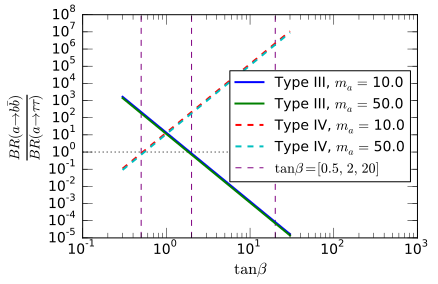

In [76]:
plt.gcf().set_size_inches(6, 4)
for m, br in zip(m_a_few, br_ratio_typ3_masses):
    plt.plot(tg_beta, br, label='Type III, '+r'$m_a =\ $' + str(m), linewidth=2)

for m, br in zip(m_a_few, br_ratio_typ4_masses):
    plt.plot(tg_beta, br, label='Type IV, '+r'$m_a =\ $' + str(m), linestyle='dashed', linewidth=2)

plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$\frac{BR(a\to b\bar{b})}{BR(a\to \tau\tau)}$', fontsize=20)
plt.xlabel(r'$\tan\beta$')
plt.hlines(1, *plt.xlim(), linestyle='dotted')
plt.vlines([0.5, 2, 20], *plt.ylim(), linestyle='dashed', 
           color='purple', linewidth=1, label=r'$\tan\beta = [0.5,\ 2,\ 20]$')
# plt.grid()
leg = plt.legend(loc=0, fontsize=14)
leg.get_frame().set_alpha(1)
plt.xlim(right=1E3)

# Absolute values of BR(a -> ff)

To plot BR(h->aa), we need the absolute values of BR(a->ff). This is not trivial, and depends on $\tan(\beta)$...

In [77]:
def width_a_to_ll(m_a, m_l, model_type, tan_beta):
    """Calculate BR(a->lepton lepton).
    
    model_type : {1, 2, 3, 4}
    """
    coupling = g_all(model_type, tan_beta)
    return (G_F * coupling**2 * m_a * m_l**2 * velocity(m_l, m_a)) / (4. * sqrt2 * PI)

In [78]:
def width_a_to_qq(m_a, m_quark_fn, quark_type, model_type, tan_beta):
    """Calculate BR(a->qq). Not valid for top quark pairs!
        
    m_quark_fn : function for calculating running quark mass. 
        Will be evaulated at scale m_a
    quark_type : {'up', 'down'}
        In 2HDM+S, up type always couples to H2, so always cot(beta) factor.
        For down type, evaulates coupling for specified model_type and tan_beta
    model_type : {1, 2, 3, 4}
    """
    coupling = 1./tan_beta if quark_type == 'up' else g_aqq_down(model_type, tan_beta)
    m_quark = m_quark_fn(m_a)
#     print rad_corr(m_quark, m_a)
    return (3. * G_F * coupling**2 * m_a * m_quark**2 * velocity(m_quark, m_a) * rad_corr(m_quark, m_a)) / (4 * sqrt2 * PI)


In [79]:
width_a_to_qq(4, m_b_msbar, 'down', 1, 1)

0.0

In [80]:
@jit
def universal_scaling_fn(x):
    if x <= 1:
        return np.arcsin(np.sqrt(x))**2
    else:
        sqrt_thing = np.sqrt(1.-(1./x))
        return -0.25 * (np.log((1. + sqrt_thing) / (1. - sqrt_thing)) - np.pi*1j)**2

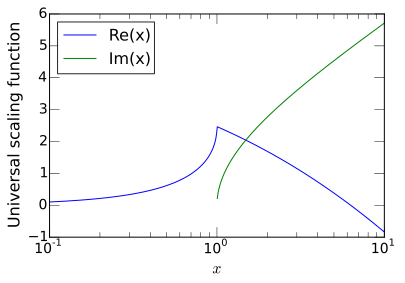

In [81]:
plt.gcf().set_size_inches(6, 4)
xxx = np.logspace(-1, 1, 500)
aaa = [universal_scaling_fn(x) for x in xxx]
plt.plot(xxx, np.real(aaa), label='Re(x)')
plt.plot(xxx[xxx>1], np.imag(aaa)[np.imag(aaa)>0], label='Im(x)')
plt.xscale('log')
plt.xlabel(r'$x$')
plt.ylabel('Universal scaling function')
plt.legend(loc=0)

In [82]:
@jit
def amplitude_spin_half(x):
    return 2. * universal_scaling_fn(x) / x

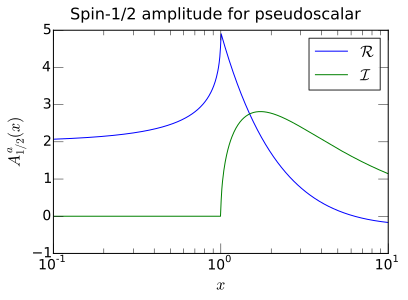

In [83]:
plt.gcf().set_size_inches(6, 4)
plt.plot(xxx, [np.real(amplitude_spin_half(x)) for x in xxx], label=r'$\mathcal{R}$')
plt.plot(xxx, [np.imag(amplitude_spin_half(x)) for x in xxx], label=r'$\mathcal{I}$')
plt.xscale('log')
plt.xlabel(r'$x$')
plt.ylabel(r'$A^a_{1/2}(x)$')
plt.suptitle('Spin-1/2 amplitude for pseudoscalar')
plt.legend(loc=0)

In [84]:
# dict of fermions that go into gamma gamma calculation
fermions = {
    'c': {'NC': 3, 'm': m_c_msbar, 'g': g_aqq_up, 'Q': 2./3}, 
    's': {'NC': 3, 'm': m_s_msbar, 'g': g_aqq_down, 'Q': -1./3}, 
    't': {'NC': 3, 'm': m_t_msbar, 'g': g_aqq_up, 'Q': 2./3}, 
    'b': {'NC': 3, 'm': m_b_msbar, 'g': g_aqq_down, 'Q': -1./3}, 
    'mu': {'NC': 1, 'm': m_mu, 'g': g_all, 'Q': -1.}, 
    'tau': {'NC': 1, 'm': m_tau, 'g': g_all, 'Q': -1.}
}


In [85]:
def width_a_to_gamgam(m_a, model_type, tan_beta):
    """Calculate BR(a->gamma gamma)
    
    model_type : {1, 2, 3, 4}
    """
    # setup couplings
    contrib = np.array([v['NC'] * v['Q']**2 * v['g'](model_type, tan_beta) * 
                        amplitude_spin_half(m_a**2 / (4. * v['m'](m_a)**2)) 
               for v in fermions.itervalues() if v['m'](m_a) > 0])
#     print np.array(contrib)
    return (G_F * A_QED**2 * m_a**2 * np.real(np.sum(contrib * np.conj(contrib)))) / (128. * sqrt2 * PI**3)

In [86]:
# dict of quarks that go into the gluglu calculation
quarks = {
#             'u': {'NC': 3, 'm': None, 'g': None, 'Q': 2./3}, 
#             'd': {'NC': 3, 'm': None, 'g': g_aqq_down, 'Q': -1./3}, 
            'c': {'NC': 3, 'm': m_c_msbar, 'g': g_aqq_up, 'Q': 2./3}, 
#             's': {'NC': 3, 'm': m_s_msbar, 'g': g_aqq_down, 'Q': -1./3}, 
            't': {'NC': 3, 'm': m_t_msbar, 'g': g_aqq_up, 'Q': 2./3}, 
            'b': {'NC': 3, 'm': m_b_msbar, 'g': g_aqq_down, 'Q': -1./3}, 
}
n_q = len(quarks)

In [87]:
def width_a_to_gluglu(m_a, model_type, tan_beta):
    """Calculate BR(a->gluon gluon)
    
    model_type : {1, 2, 3, 4}
    """
    contrib = np.array([0.75 * v['g'](model_type, tan_beta) * amplitude_spin_half(m_a**2 / (4. * v['m'](m_a)**2)) 
               for v in quarks.itervalues() if v['m'](m_a) > 0])
#     print np.array(contrib)
    a_s = alpha_s(m_a)
    rad_corr = (1. + ((97./4.) - (7. * n_q/ 6.)) * (a_s/PI))
#     print rad_corr
    return (G_F * a_s**2 * m_a**3 * np.real(np.sum(contrib * np.conj(contrib)))) / (36. * sqrt2 * PI**3)

In [88]:
def total_width(m_a, model_type, tan_beta):
    return sum([
        width_a_to_ll(m_a, M_MU, model_type, tan_beta),
        width_a_to_ll(m_a, M_TAU, model_type, tan_beta),
        width_a_to_qq(m_a, m_b_msbar, 'down', model_type, tan_beta),
        width_a_to_qq(m_a, m_c_msbar, 'up', model_type, tan_beta),
        width_a_to_qq(m_a, m_s_msbar, 'down', model_type, tan_beta),
        width_a_to_gamgam(m_a, model_type, tan_beta),
        width_a_to_gluglu(m_a, model_type, tan_beta)
      ])


In [89]:
mmm = np.logspace(np.log10(4), np.log10(50), 200)
widths_typ1 = np.array([total_width(m, 1, 1) for m in mmm])
widths_typ2_tb0p5 = np.array([total_width(m, 2, 0.5) for m in mmm])
widths_typ2_tb5 = np.array([total_width(m, 2, 5) for m in mmm])
widths_typ3_tb0p5 = np.array([total_width(m, 3, 0.5) for m in mmm])
widths_typ3_tb5 = np.array([total_width(m, 3, 5) for m in mmm])
widths_typ4_tb0p5 = np.array([total_width(m, 4, 0.5) for m in mmm])
widths_typ4_tb5 = np.array([total_width(m, 4, 5) for m in mmm])

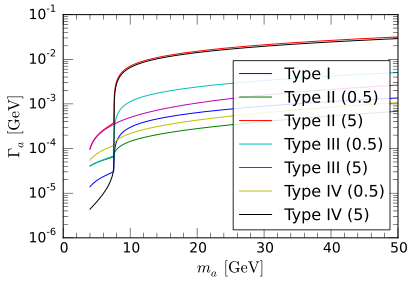

In [90]:
plt.gcf().set_size_inches(6, 4)
plt.plot(mmm, widths_typ1, label='Type I')
plt.plot(mmm, widths_typ2_tb0p5, label='Type II (0.5)')
plt.plot(mmm, widths_typ2_tb5, label='Type II (5)')
plt.plot(mmm, widths_typ3_tb0p5, label='Type III (0.5)')
plt.plot(mmm, widths_typ3_tb5, label='Type III (5)')
plt.plot(mmm, widths_typ4_tb0p5, label='Type IV (0.5)')
plt.plot(mmm, widths_typ4_tb5, label='Type IV (5)')
plt.legend(loc=0)
plt.yscale('log')
plt.ylabel(r'$\Gamma_a\ \mathrm{[GeV]}$')
plt.xlabel(r'$m_a\ \mathrm{[GeV]}$')
plt.minorticks_on()

In [91]:
def br_a_mumu(m_a, model_type, tan_beta):
    return width_a_to_ll(m_a, M_MU, model_type, tan_beta) / total_width(m_a, model_type, tan_beta)

In [92]:
def br_a_tautau(m_a, model_type, tan_beta):
    return width_a_to_ll(m_a, M_TAU, model_type, tan_beta) / total_width(m_a, model_type, tan_beta)

In [93]:
def br_a_bb(m_a, model_type, tan_beta):
    return width_a_to_qq(m_a, m_b_msbar, 'down', model_type, tan_beta) / total_width(m_a, model_type, tan_beta)

In [94]:
def br_a_cc(m_a, model_type, tan_beta):
    return width_a_to_qq(m_a, m_c_msbar, 'up', model_type, tan_beta) / total_width(m_a, model_type, tan_beta)

In [95]:
def br_a_ss(m_a, model_type, tan_beta):
    return width_a_to_qq(m_a, m_s_msbar, 'down', model_type, tan_beta) / total_width(m_a, model_type, tan_beta)

In [96]:
def br_a_gluglu(m_a, model_type, tan_beta):
    return width_a_to_gluglu(m_a, model_type, tan_beta) / total_width(m_a, model_type, tan_beta)

In [97]:
def br_a_gamgam(m_a, model_type, tan_beta):
    return width_a_to_gamgam(m_a, model_type, tan_beta) / total_width(m_a, model_type, tan_beta)

In [98]:
def make_br_plot(model_type, tan_beta):
    masses = np.logspace(np.log10(1.5), np.log10(62), 500)
    br_taus = np.array([br_a_tautau(m, model_type, tan_beta) for m in masses])
    br_mus = np.array([br_a_mumu(m, model_type, tan_beta) for m in masses])
    br_bs = np.array([br_a_bb(m, model_type, tan_beta) for m in masses])
    br_cs = np.array([br_a_cc(m, model_type, tan_beta) for m in masses])
    br_ss = np.array([br_a_ss(m, model_type, tan_beta) for m in masses])
    br_glus = np.array([br_a_gluglu(m, model_type, tan_beta) for m in masses])
    br_gammas = np.array([br_a_gamgam(m, model_type, tan_beta) for m in masses])
#     br_total = br_taus + br_mus + br_bs + br_cs + br_ss + br_glus + br_gammas
    
    lw = 2
    plt.plot(masses[br_taus>0], br_taus[br_taus>0], label=r'$\tau\tau$', 
             linestyle='dotted', color='firebrick', linewidth=lw)
    plt.plot(masses[br_mus>0], br_mus[br_mus>0], label=r'$\mu\mu$', 
             linestyle='dotted', color='purple', linewidth=lw)
    plt.plot(masses[br_bs>0], br_bs[br_bs>0], label=r'$bb$', 
             color='red', linewidth=lw)
    plt.plot(masses[br_cs>0], br_cs[br_cs>0], label=r'$cc$', 
             color='deepskyblue', linewidth=lw)
    plt.plot(masses[br_ss>0], br_ss[br_ss>0], label=r'$ss$', 
             color='black', linewidth=lw)
    plt.plot(masses[br_glus>0], br_glus[br_glus>0], label=r'$gg$', 
             linestyle='dashdot', color='blue', linewidth=lw)
    plt.plot(masses[br_gammas>0], br_gammas[br_gammas>0], label=r'$\gamma\gamma$', 
             linestyle='dashed', color='green', linewidth=lw)

    plt.legend(loc=0)
    ax = plt.gca()
    ax.set_xlabel(r'$m_a\ \mathrm{[GeV]}$')
    ax.set_ylabel(r'$BR(a\to XX)$')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1, 62)
    ax.set_ylim(1E-4, 1.1)
    ax.set_title('Type %s, ' % int_to_roman(model_type) + r'$\tan\beta\ =\ $' + '%g' % tan_beta, 
                 fontsize=22, y=1.02)
    
    # shaded regions for resonances
    y_lim = ax.get_ylim()
    ax.add_patch(patches.Rectangle((3, y_lim[0]), 2.1, y_lim[1]-y_lim[0], color='grey', alpha=0.5))
    ax.add_patch(patches.Rectangle((9.3, y_lim[0]), 2.3, y_lim[1]-y_lim[0], color='grey', alpha=0.5))

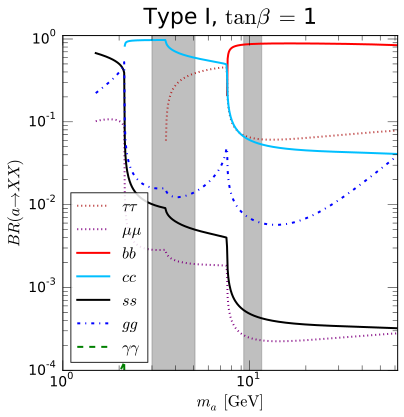

In [99]:
plt.gcf().set_size_inches(6, 6)
make_br_plot(1, 1)

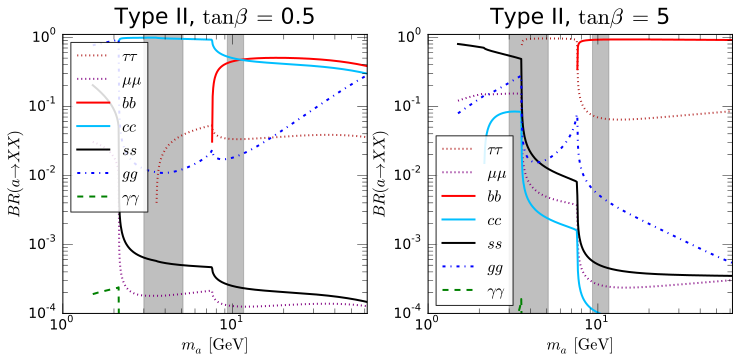

In [100]:
plt.gcf().set_size_inches(12, 5)
plt.subplot(1, 2, 1)
model = 2
make_br_plot(model, 0.5)
plt.subplot(1, 2, 2)
make_br_plot(model, 5)

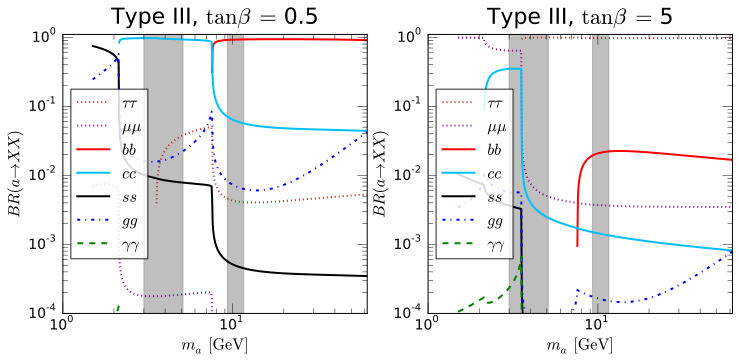

In [101]:
plt.gcf().set_size_inches(12, 5)
plt.subplot(1, 2, 1)
model = 3
make_br_plot(model, 0.5)
plt.subplot(1, 2, 2)
make_br_plot(model, 5)

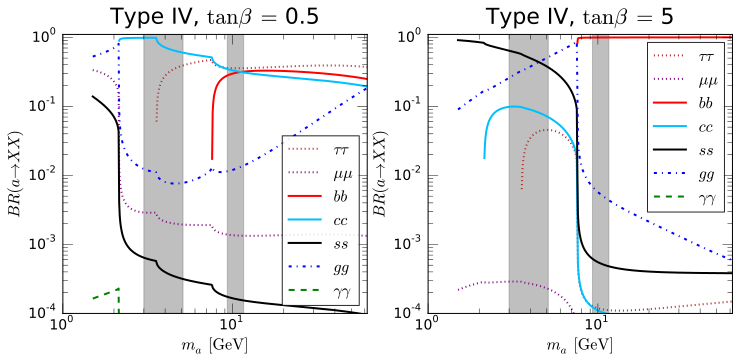

In [102]:
plt.gcf().set_size_inches(12, 5)
plt.subplot(1, 2, 1)
model = 4
make_br_plot(model, 0.5)
plt.subplot(1, 2, 2)
make_br_plot(model, 5)

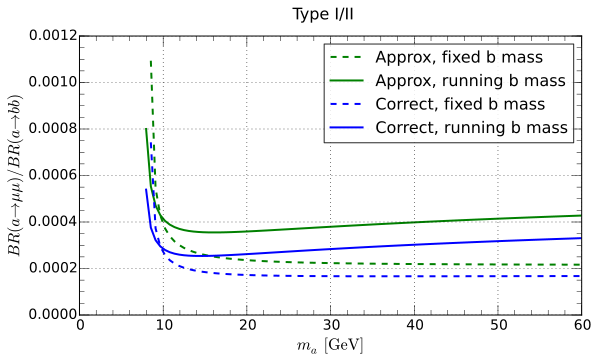

In [103]:
mmm = np.linspace(4, 60, 100)
plt.plot(mmm, [convert_BR_final_states_simple(M_MU, M_B_MSBAR_AT_POLE, m)/3. for m in mmm], 
         label='Approx, fixed b mass', linestyle='dashed', color='green', linewidth=2)
plt.plot(mmm, [convert_BR_final_states_simple(M_MU, m_b_msbar(m), m)/3. for m in mmm], 
         label='Approx, running b mass', color='green', linewidth=2)
plt.plot(mmm, [width_a_to_ll(m, M_MU, 1, 1) / width_a_to_qq(m, lambda x: M_B_MSBAR_AT_POLE, 'down', 1, 1) for m in mmm], 
         label='Correct, fixed b mass', linestyle='dashed', color='blue', linewidth=2)
plt.plot(mmm, [width_a_to_ll(m, M_MU, 1, 1) / width_a_to_qq(m, m_b_msbar, 'down', 1, 1) for m in mmm], 
         label='Correct, running b mass', color='blue', linewidth=2)
plt.legend()
plt.ylabel(r"$BR(a \to \mu\mu) / BR(a \to bb)$")
plt.xlabel(M_a_STR)
plt.minorticks_on()
plt.grid()
plt.suptitle("Type I/II")